In [1]:
from pathlib import Path
base_folder = Path("/home/bread/Downloads/")

In [2]:
data_folder = base_folder/"inclassdl"
model_folder = base_folder/"models/inclassdl"
archive_folder = base_folder/"archive"

In [3]:
data_folder.mkdir(exist_ok= True)
model_folder.mkdir(exist_ok= True)
archive_folder.mkdir(exist_ok= True)

In [4]:
from fastai.vision.all import *
# from kaggle import api
from fastcore.parallel import *

/home/bread/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_path = data_folder/'train'
test_path = data_folder/'test'
train_files = get_image_files(train_path)
test_files = get_image_files(test_path)

In [6]:
test_files

(#3929) [Path('/home/bread/Downloads/inclassdl/test/test/2751.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/1696.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/1617.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/575.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/3788.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/947.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/3102.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/3532.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/3757.JPEG'),Path('/home/bread/Downloads/inclassdl/test/test/2656.JPEG')...]

In [39]:
dblock = DataBlock(blocks = [ImageBlock, CategoryBlock],
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(seed = 42),
                   item_tfms= Resize(size= 180, method = 'squish'),
                   batch_tfms= aug_transforms(size = 128, min_scale = 1)
                   )

In [40]:
dls = dblock.dataloaders(data_folder/'train/train', bs = 64)

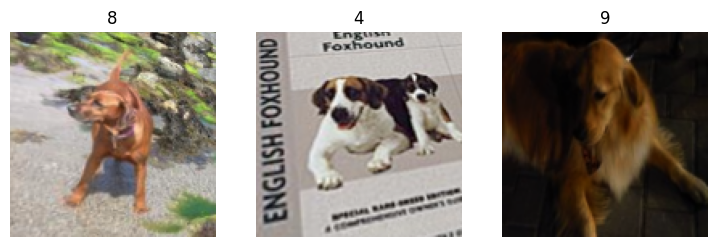

In [44]:
dls.train.show_batch(max_n = 3)

In [19]:
import timm
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [34]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [43]:
report_gpu()

GPU:0
process      10158 uses     2119.000 MB GPU memory


In [45]:
learn = vision_learner(dls, 'convnext_small', metrics= error_rate, path = model_folder).to_fp16()

SuggestedLRs(minimum=0.04365158379077912, steep=0.0831763744354248, valley=0.005248074419796467, slide=0.02754228748381138)

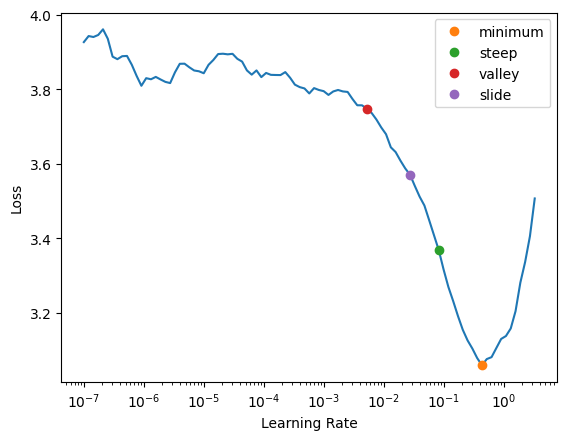

In [47]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [48]:
torch.cuda.empty_cache()
learn.fine_tune(3, 0.04)

epoch,train_loss,valid_loss,error_rate,time
0,1.090919,0.175533,0.055956,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.323640,0.142154,0.044321,00:32
1,0.282911,0.130101,0.037673,00:32
2,0.251908,0.129489,0.037673,00:32


In [73]:
learn.save(file=model_folder/'convnext_small')

Path('/home/bread/Downloads/models/inclassdl/convnext_small.pth')

In [49]:
test_dl = dls.test_dl(test_files)

In [50]:
preds, _ = learn.tta(dl = test_dl)

In [62]:
idxs = preds.argmax(dim = 1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name = 'idxs')

In [67]:
idxs

TensorBase([2, 5, 9,  ..., 9, 4, 9])

In [68]:
vocab[idxs]

array(['2', '5', '9', ..., '9', '4', '9'], dtype='<U1')

In [58]:
ss = pd.read_csv(data_folder/'sample_submission.csv')
ss['target'] = 0
ss.head(10)

,file_names,target
0,0.JPEG,0
1,1.JPEG,0
2,2.JPEG,0
3,3.JPEG,0
4,4.JPEG,0
5,5.JPEG,0
6,6.JPEG,0
7,7.JPEG,0
8,8.JPEG,0
9,9.JPEG,0


In [59]:
ss.sort_values(by = ['file_names'], inplace = True, ignore_index = True)
ss.head(10)

,file_names,target
0,0.JPEG,0
1,1.JPEG,0
2,10.JPEG,0
3,100.JPEG,0
4,1000.JPEG,0
5,1001.JPEG,0
6,1002.JPEG,0
7,1003.JPEG,0
8,1004.JPEG,0
9,1005.JPEG,0


In [60]:
ss['target'] = results

In [61]:
ss.head()

,file_names,target
0,0.JPEG,2
1,1.JPEG,5
2,10.JPEG,9
3,100.JPEG,5
4,1000.JPEG,4


In [54]:
ss.to_csv(archive_folder/'conv_small.csv', index = False)